<a href="https://colab.research.google.com/github/yibesh/DeepLearning/blob/main/LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense


In [17]:
# -----------------------------
# 1. Simulate Temperature Dataset
# -----------------------------
np.random.seed(42)  # for reproducibility

days = 365  # one year of data
base_date = datetime(2024, 1, 1)  # starting date

# Create a list of dates for one year
dates = [base_date + timedelta(days=i) for i in range(days)]

# Simulate temperature data:
# Base temp 15°C + seasonal sinusoidal variation + random noise
temperatures = 15 + 10 * np.sin(np.linspace(0, 2 * np.pi, days)) + np.random.normal(0, 1.5, days)

# Create a DataFrame
df = pd.DataFrame({"Date": dates, "Temperature_C": temperatures})

# Display first 5 rows to check the data
print("Sample Dataset:")
print(df.head())

# Save dataset to CSV for future use
csv_filename = "simulated_temperature_dataset.csv"
df.to_csv(csv_filename, index=False)
print(f"Dataset saved as: {csv_filename}")

Sample Dataset:
        Date  Temperature_C
0 2024-01-01      15.745071
1 2024-01-02      14.965210
2 2024-01-03      16.316694
3 2024-01-04      17.802158
4 2024-01-05      15.338681
Dataset saved as: simulated_temperature_dataset.csv


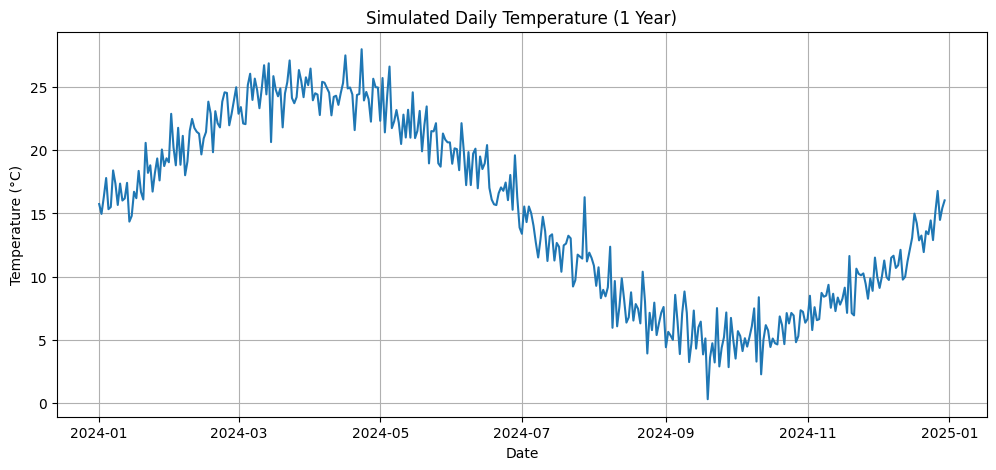

In [18]:
# Plot the temperature data to visualize trends
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Temperature_C"])
plt.title("Simulated Daily Temperature (1 Year)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

In [19]:
# -----------------------------
# 2. Prepare Data for LSTM/GRU
# -----------------------------
# LSTM/GRU models work better with scaled data
scaler = MinMaxScaler()
temps_scaled = scaler.fit_transform(df["Temperature_C"].values.reshape(-1,1))

# Function to create input-output sequences (sliding window)
# Inputs: previous 'window_size' time steps
# Output: next temperature value
def create_dataset(series, window_size=20):
    X, y = [], []
    for i in range(len(series)-window_size):
        X.append(series[i:i+window_size])  # input sequence
        y.append(series[i+window_size])    # target value
    return np.array(X), np.array(y)

window_size = 20  # number of past time steps the model will see
X, y = create_dataset(temps_scaled, window_size)

# Split into training and testing sets (80% train, 20% test)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data to 3D for RNN input: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [20]:
# -----------------------------
# 3. Build and Train LSTM Model
# -----------------------------
# Define LSTM model
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size,1)),  # 50 LSTM units
    Dense(1)  # output layer for predicting next temperature
])

lstm_model.compile(optimizer='adam', loss='mse')  # use Mean Squared Error loss
lstm_model.summary()

# Train the model
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # monitor validation loss
    epochs=30,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.4587 - val_loss: 0.0430
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1094 - val_loss: 0.0144
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0308 - val_loss: 0.0051
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0126 - val_loss: 0.0033
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0135 - val_loss: 0.0039
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0097 - val_loss: 0.0033
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043 - val_loss: 0.0037
E

In [21]:
# Predict on test set
lstm_pred = lstm_model.predict(X_test)
# Convert scaled predictions back to original temperature scale
lstm_pred_actual = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [22]:
# -----------------------------
# 4. Build and Train GRU Model
# -----------------------------
# GRU is similar to LSTM but simpler and faster
gru_model = Sequential([
    GRU(50, activation='tanh', input_shape=(window_size,1)),  # 50 GRU units
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()

# Train the GRU model
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0990 - val_loss: 0.0045
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0128 - val_loss: 0.0151
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0139 - val_loss: 0.0026
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033 - val_loss: 0.0023
E

In [23]:
# Predict on test set
gru_pred = gru_model.predict(X_test)
gru_pred_actual = scaler.inverse_transform(gru_pred)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


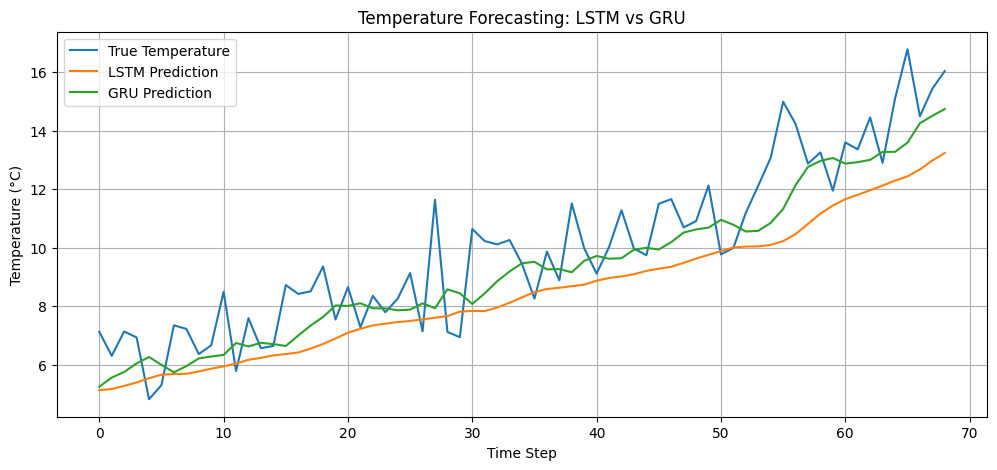

In [24]:
# -----------------------------
# 5. Plot Predictions vs True Values
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='True Temperature')       # actual temperatures
plt.plot(lstm_pred_actual, label='LSTM Prediction')    # LSTM predictions
plt.plot(gru_pred_actual, label='GRU Prediction')      # GRU predictions
plt.title("Temperature Forecasting: LSTM vs GRU")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()